# **Cardiac Data Quality Assessment**

This notebook outlines quality assessment and control procedures on electrocardiograph (ECG) and photoplethysmograph (PPG) data.

In [ ]:
!git clone https://github.com/nmy2103/physiological-sensing-lecture.git
%cd physiological-sensing-lecture
!pip install -e . # install heartview

## Imports

In [1]:
import pandas as pd
from utils import *
from heartview import *

## ECG Data
Load the pre-processed ECG data. The sampling frequency is 1024 Hz.

In [2]:
ecg = pd.read_csv('data/sample_ecg_preprocessed.csv')
ecg['Timestamp'] = pd.to_datetime(ecg['Timestamp'])
ecg_fs = 1024
ecg.head()

,Segment,Timestamp,ECG,Filtered,Beat_Manikandan,Beat_Engzee,Beat_PanTompkins
0,1,2017-03-18 14:57:18.000000,0.110697,0.008806,NaN,NaN,NaN
1,1,2017-03-18 14:57:18.000977,0.110697,0.004319,NaN,NaN,NaN
2,1,2017-03-18 14:57:18.001953,0.102508,-0.000172,NaN,NaN,NaN
3,1,2017-03-18 14:57:18.002930,0.078527,-0.004629,NaN,NaN,NaN
4,1,2017-03-18 14:57:18.003906,0.081159,-0.009015,NaN,NaN,NaN


### ECG Quality Assessment

In [3]:
ecgqa = cardio_sqa(ecg_fs)

#### **Time Domain**
Time domain-based quality assessment methods focus on abnormal timing of detected beats or interbeat intervals (IBIs). Based on aberrant IBIs, we can approximate how many beats might be missing or artifactual from a segment.

A popular time domain-based artifact identification method is the 'criterion beat difference' test by Berntson et al. (1990).  
**Reference:** Berntson, G. G., Quigley, K. S., Jang, J. F., & Boysen, S. T. (1990). An approach to artifact identification: Application to heart period data. _Psychophysiology, 27_(5), 586-598.

1. Obtain an array of all beats detected by one of the beat detection algorithms.

In [4]:
ecg_beats = ecg[ecg.Beat_Manikandan == 1].index.values

2. Evaluate for abnormal beats according to the criterion beat difference test.

In [5]:
artifact_beats = ecgqa.identify_artifacts(ecg_beats, method = 'cbd')
ecg.loc[artifact_beats, 'Artifact'] = 1
interactive_plot(ecg, 'Timestamp', 'Filtered', beats = 'Beat_Manikandan', artifacts = 'Artifact');

interactive(children=(IntSlider(value=1, description='Segment:', max=15, min=1), Output()), _dom_classes=('wid…

3. Summarize the proportions of missing and artifactual beats by segment.

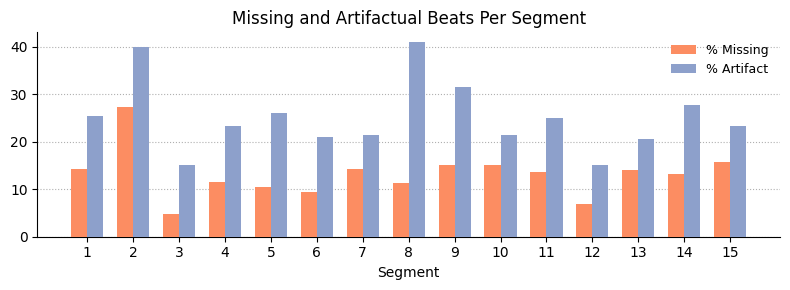

In [6]:
time_domain_qa = ecgqa.compute_metrics(ecg, ecg_beats, artifact_beats, ts_col = 'Timestamp', show_progress = False)
summary_plot(time_domain_qa, x = 'Segment', y = ['% Missing', '% Artifact'], title = 'Missing and Artifactual Beats Per Segment')

#### **Frequency Domain**  
Frequency domain-based quality assessment methods focus on the amount of distortion in signal waveforms. A popular metric is the **signal-to-noise ratio (SNR)**. The greater the SNR, the better the signal quality.

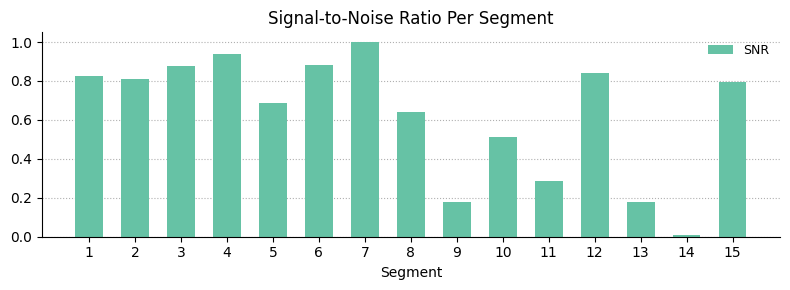

In [7]:
snr = ecgqa.compute_snr(ecg['ECG'], ecg['Filtered'], method = 'both')
summary_plot(snr, x = 'Segment', y = 'SNR', title = 'Signal-to-Noise Ratio Per Segment')

## PPG Data
Load the pre-processed PPG data. The sampling frequency is 64 Hz.

In [8]:
ppg = pd.read_csv('data/sample_ppg_preprocessed.csv')
ppg['Timestamp'] = pd.to_datetime(ppg['Timestamp'])
ppg_fs = 64
ppg.head()

,Segment,Timestamp,BVP,Filtered,Beat_AdaptThresh,Beat_ERMA
0,1,2021-11-15 22:59:26.000000,99.67,21.868079,NaN,NaN
1,1,2021-11-15 22:59:26.015625,99.74,23.820794,NaN,NaN
2,1,2021-11-15 22:59:26.031250,99.43,24.575399,1.0,NaN
3,1,2021-11-15 22:59:26.046875,97.86,23.937594,NaN,NaN
4,1,2021-11-15 22:59:26.062500,93.65,21.810341,NaN,NaN


### PPG Quality Assessment

In [9]:
ppgqa = cardio_sqa(ppg_fs)

Run the same time- and frequency-domain quality assessment procedures from above.

In [10]:
ppg_beats = ppg[ppg.Beat_ERMA == 1].index.values

#### **Time Domain**

1. Identify artifactual beats.

In [11]:
artifact_beats = ppgqa.identify_artifacts(ppg_beats, method = 'cbd')
ppg.loc[artifact_beats, 'Artifact'] = 1
interactive_plot(ppg, 'Timestamp', 'Filtered', beats = 'Beat_ERMA', artifacts = 'Artifact');

interactive(children=(IntSlider(value=1, description='Segment:', max=20, min=1), Output()), _dom_classes=('wid…

2. Summarize the proportion of missing and artifactual beats by segment.

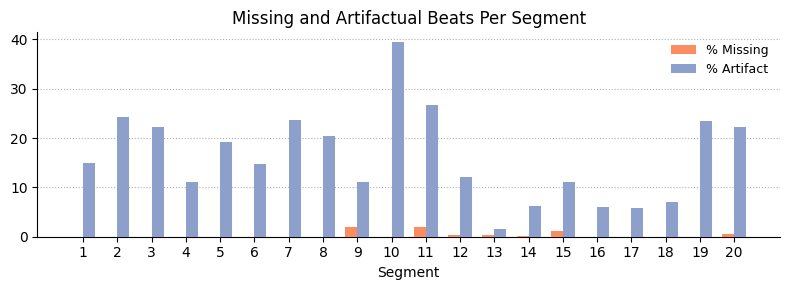

In [12]:
time_domain_qa = ppgqa.compute_metrics(ppg, ppg_beats, artifact_beats, ts_col = 'Timestamp', show_progress = False)
summary_plot(time_domain_qa, x = 'Segment', y = ['% Missing', '% Artifact'], kind = 'bar', title = 'Missing and Artifactual Beats Per Segment')

#### **Frequency Domain**

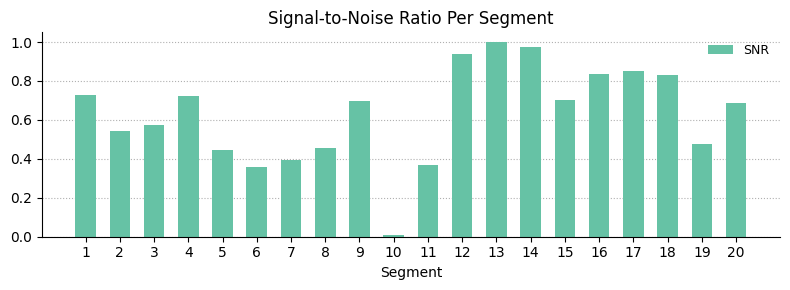

In [13]:
snr = ppgqa.compute_snr(ppg['BVP'], ppg['Filtered'], method = 'both')
summary_plot(snr, x = 'Segment', y = 'SNR', title = 'Signal-to-Noise Ratio Per Segment')